In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

Text(0, 0.5, 'y')

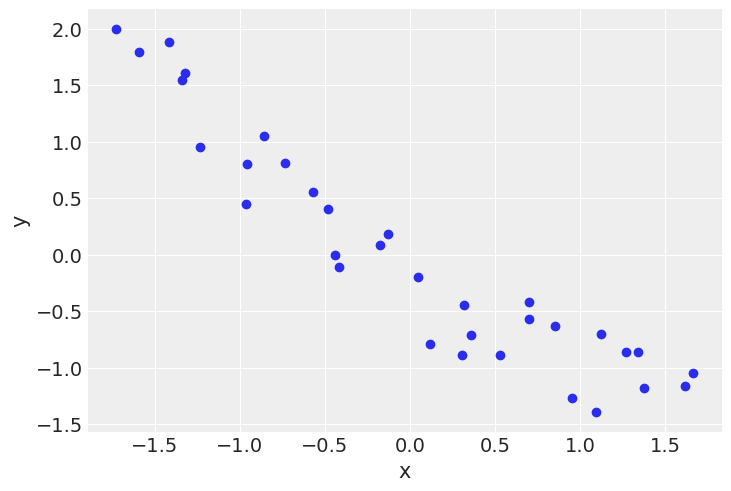

In [3]:
dummy_data = np.loadtxt('./data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / \
    x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

In [4]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    idata_l = pm.sample(2000, return_inferencedata=True)
# linear model
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    idata_p = pm.sample(2000, return_inferencedata=True)
    
# parabolic model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 35 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 47 seconds.


모델 비교를 위한 2개의 모델 생성.  
선형모델과 포물선 모델 생성

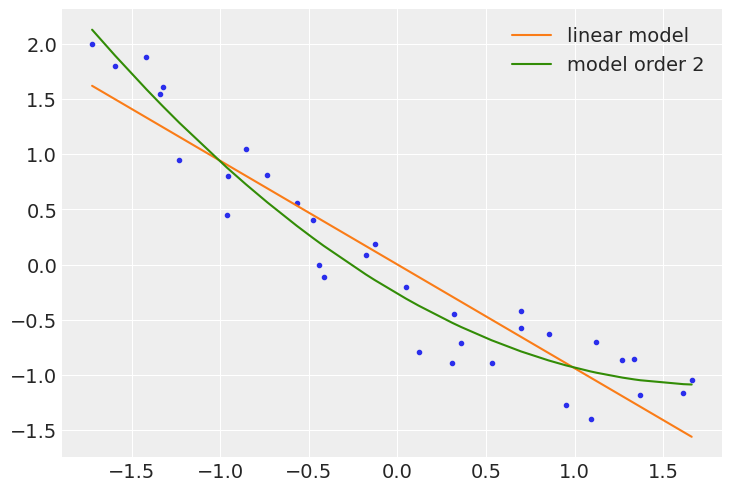

In [5]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = idata_l.posterior['α'].mean(("chain", "draw")).values
β_l_post = idata_l.posterior['β'].mean(("chain", "draw")).values
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = idata_p.posterior['α'].mean(("chain", "draw")).values
β_p_post = idata_p.posterior['β'].mean(("chain", "draw")).values
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

In [6]:
y_l = pm.sample_posterior_predictive(idata_l, 2000, model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(idata_p, 2000, model=model_p)['y_pred']

C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Anaconda3\envs\pymc_env\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


([], [])

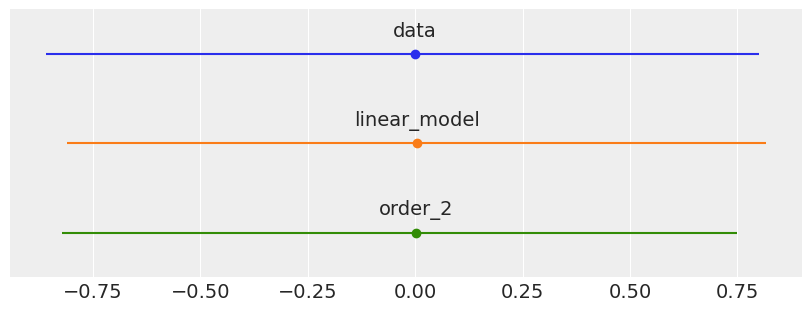

In [7]:
plt.figure(figsize=(8,3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear_model', 'order_2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

평균과 IQR를 비교해보면 둘다 잘 설명을 하는 것 같지만, mean과 IQR의 dispersion을 그려보고 비교를 해보겠다.

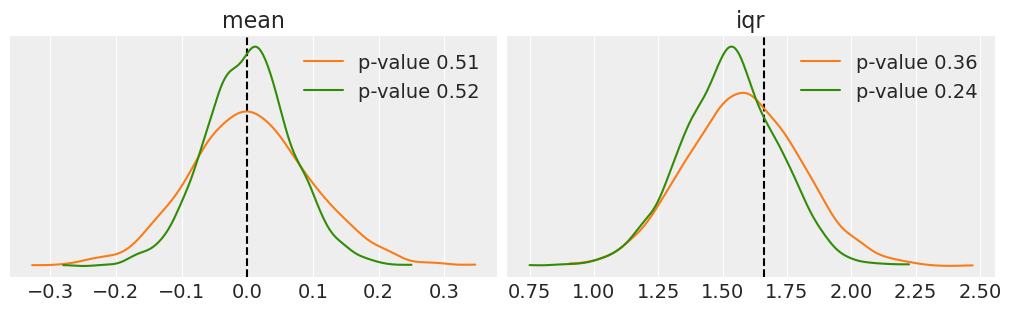

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color = 'k', ls='--')
    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color':c}, label=f'p-value {p_value:.2f}', ax=ax[idx])
        ax[idx].set_title(func.__name__)
        ax[idx].set_yticks([])
        ax[idx].legend()

## Occam's razor - simplicity and accuracy  
- 두개의 모델이 있으면 더욱 더 간단한 것을 선택

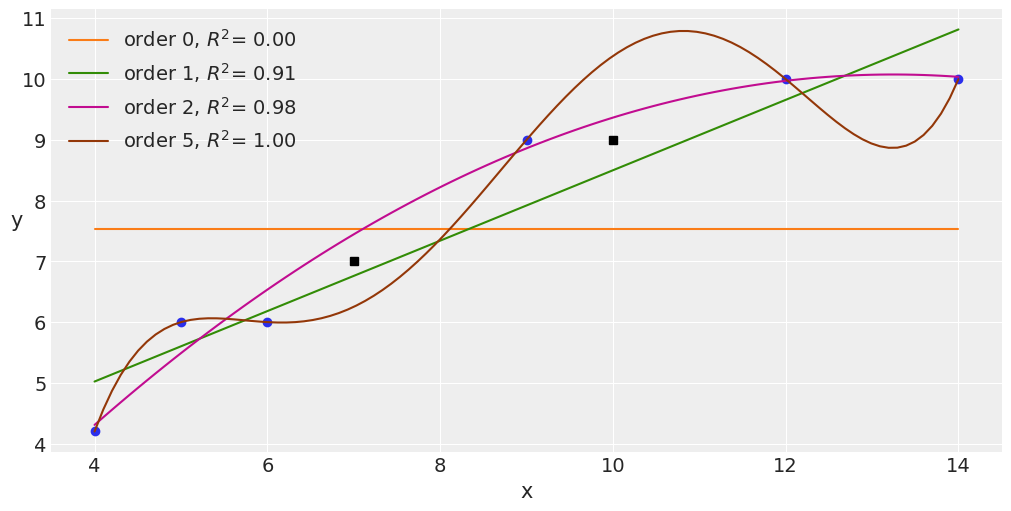

In [9]:
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])

plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')
    
plt.legend(loc=2)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.savefig('B11197_05_05.png', dpi=300)
plt.plot([10, 7], [9, 7], 'ks')

5차선형의 경우 데이터를 완벽히 예측한다.  
이것은 Overfitting의 문제를 만든다.  
Overfitting의 경우 High Variance(Low Bias) Underfitting의 경우 Low Variance(High Bias)이다.  
Variance와 Bias는 trade-off 관계여서 적절한 모델을 찾는 것이 중요하다.  
Bias가 크면 모델을 변경하는 것에 대해 inertia가 크다.

## Computing information criteria

In [10]:
waic_l = az.waic(idata_l)
waic_l

Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.37     2.66
p_waic        2.43        -

In [11]:
cmp_df = az.compare({'model_l':idata_l, 'model_p':idata_p},
                    method='BB-pseudo-BMA', ic="waic", scale="deviance")
# pseudo-BMA를 통한 모델 비교
cmp_df

C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Anaconda3\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_p,0,8.999554,2.575770,0.000000,0.998994,5.108889,0.000000,False,deviance
model_l,1,28.744210,2.429623,19.744657,0.001006,4.629559,5.327949,False,deviance


<AxesSubplot:xlabel='Deviance'>

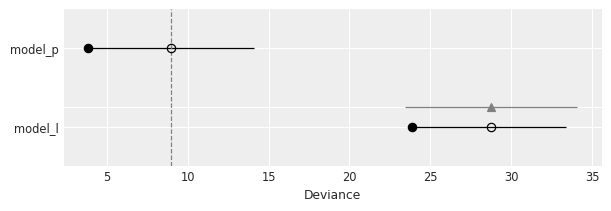

In [12]:
az.plot_compare(cmp_df)

## Model Averaging

In [13]:
w = 0.5
y_lp = pm.sample_posterior_predictive_w([idata_l, idata_p],
                                        samples=1000,
                                        models=[model_l, model_p],
                                        weights=[w, 1-w])
# 가중치에 따른 샘플 추출 가능

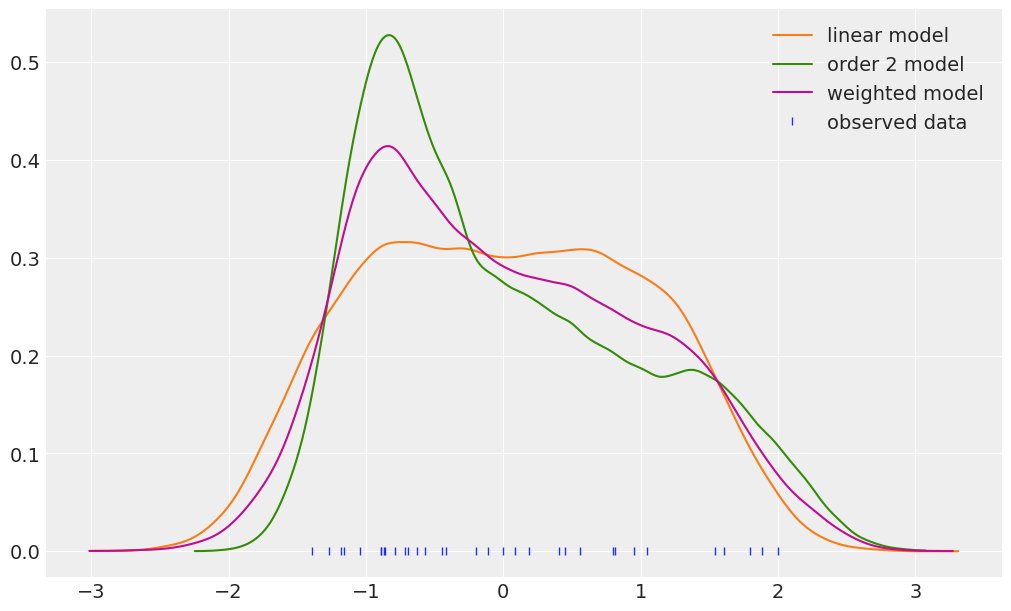

In [14]:
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_l, plot_kwargs={'color':'C1'}, label='linear model', ax = ax)
az.plot_kde(y_p, plot_kwargs={'color':'C2'}, label='order 2 model', ax = ax)
az.plot_kde(y_lp['y_pred'], plot_kwargs={'color':'C3'}, label='weighted model', ax = ax)

plt.plot(y_1s, np.zeros_like(y_1s), '|', label='observed data')
plt.yticks()
plt.legend()

## Bayes factors

Bayes Factor를 계산하여 모델을 비교가능하고, BF가 1보다 클 경우 분자에 있는 모델이 데이터를 설명 더 잘한다는 뜻이다.

In [15]:
coins = 300
heads = 90
y_d = np.repeat([0, 1], [coins-heads, heads])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 48 seconds.


array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

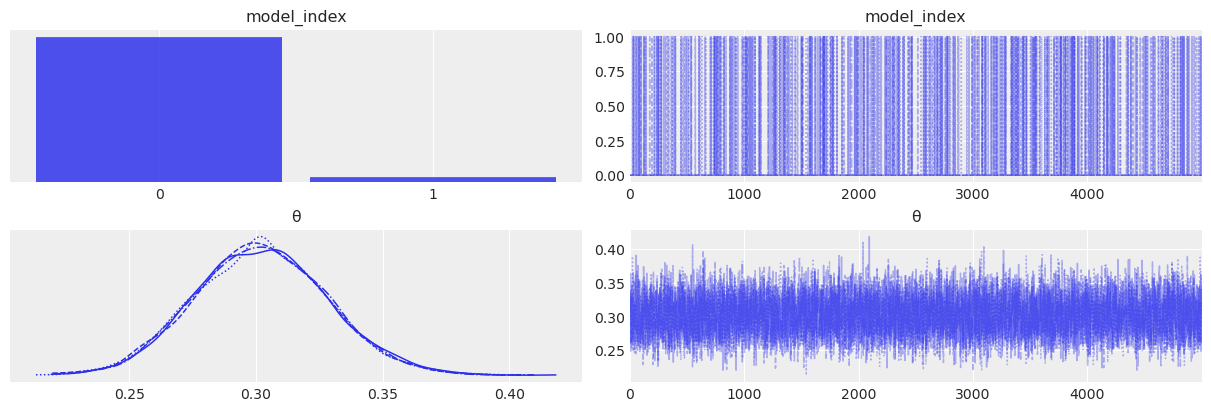

In [16]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5]) # 동전이 나올 확률 지정
    model_index = pm.Categorical('model_index', p=p)
    
    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)
    
     # a priori
    θ = pm.Beta('θ', m[0], m[1])
    # likelihood
    y = pm.Bernoulli('y', θ, observed=y_d)
    
    idata_BF = pm.sample(5000, return_inferencedata=True)
az.plot_trace(idata_BF)

In [17]:
pM1 = idata_BF.posterior['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])
f"{BF.item():.1f}"

'28.5'

In [18]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_0 = pm.sample_smc(2500)

with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_1 = pm.sample_smc(2500)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.258
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.229
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.249
Stage:   1 Beta: 1.000
Stage:   0 Beta: 0.246
Stage:   1 Beta: 1.000
Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.020
Stage:   1 Beta: 0.066
Stage:   2 Beta: 0.202
Stage:   3 Beta: 0.809
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.020
Stage:   1 Beta: 0.069
Stage:   2 Beta: 0.203
Stage:   3 Beta: 0.832
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.020
Stage:   1 Beta: 0.066
Stage:   2 Beta: 0.205
Stage:   3 Beta: 0.807
Stage:   4 Beta: 1.000
Stage:   0 Beta: 0.020
Stage:   1 Beta: 0.067
Stage:   2 Beta: 0.205
Stage:   3 Beta: 0.832
Stage:   4 Beta: 1.000


In [19]:
BF_smc = np.exp(trace_BF_0.report.log_marginal_likelihood - trace_BF_1.report.log_marginal_likelihood).mean()
f"{BF_smc:.1f}"

'26.4'

## Bayes factors and Information Criteria

In [20]:
idatas = []
waics = []
for coins, heads in [(30, 9), (300, 90)]:
    y_d = np.repeat([0, 1], [coins-heads, heads])
    for priors in [(4,8), (8,4)]:
        with pm.Model() as model:
            θ = pm.Beta('θ', *priors)
            y = pm.Bernoulli('y', θ, observed=y_d)
            idata = pm.sample(2000, return_inferencedata=True)
            idatas.append(idata)
            waics.append(az.waic(idata, scale="deviance"))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.
The acceptance probability does not match the target. It is 0.7079658545276505, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 39 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

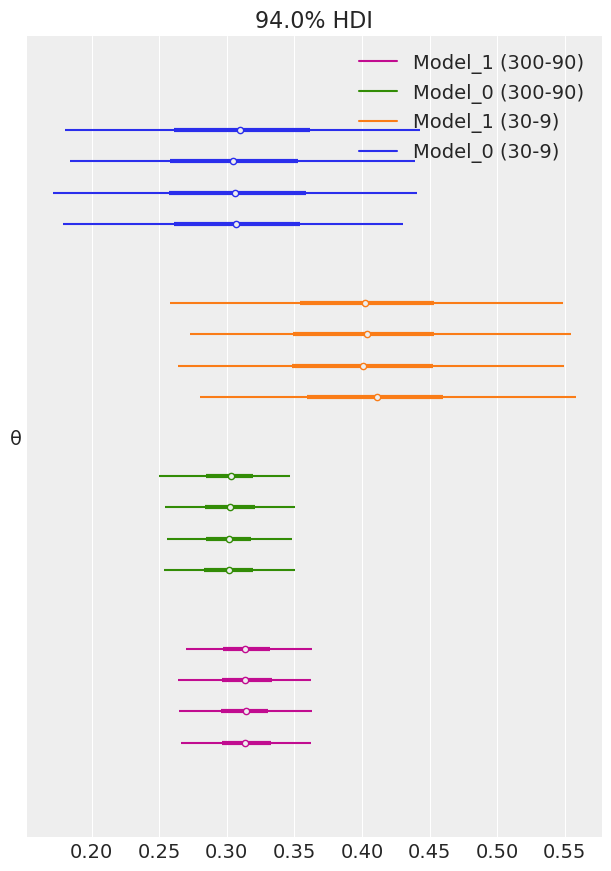

In [21]:
model_names = ['Model_0 (30-9)', 'Model_1 (30-9)',
               'Model_0 (300-90)', 'Model_1 (300-90)']

az.plot_forest(idatas, model_names=model_names)

알다시피 표본수가 늘어나니 같은 확률이여도 94%hdi 간격이 좁은 것을 확인할 수 있다.

C:\Users\User\AppData\Local\Temp\ipykernel_8504\2831201698.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(wspace=0.05)


Text(0.5, 0, 'Deviance')

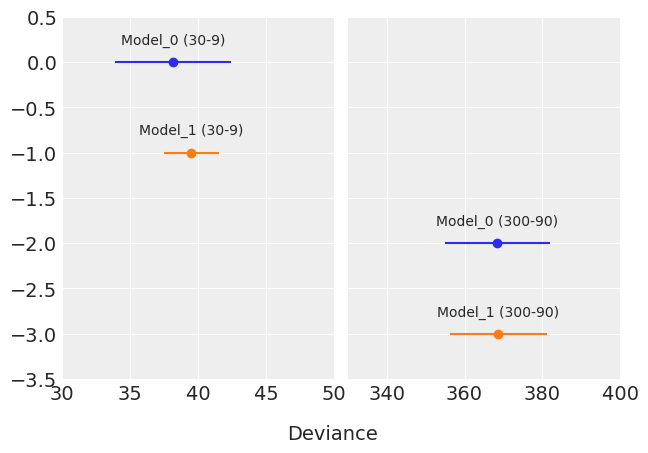

In [22]:
fig, ax = plt.subplots(1, 2, sharey=True)

labels = model_names
indices = [0, 0, 1, 1]
for i, (ind, d) in enumerate(zip(indices, waics)):
    mean = d.waic
    ax[ind].errorbar(mean, -i, xerr=d.waic_se, fmt='o')
    ax[ind].text(mean, -i+0.2, labels[i], ha='center')
    
ax[0].set_xlim(30, 50)
ax[1].set_xlim(330, 400)
plt.ylim([-i-0.5, 0.5])
plt.subplots_adjust(wspace=0.05)
fig.text(0.5, 0, 'Deviance', ha='center', fontsize = 14)

샘플리의 개수가 늘어나다보니 WAIC값은 커지나, 두 모델간의 상대적인 차이는 줄어든다.

## Regularizing priors

(-7.0, 7.0)

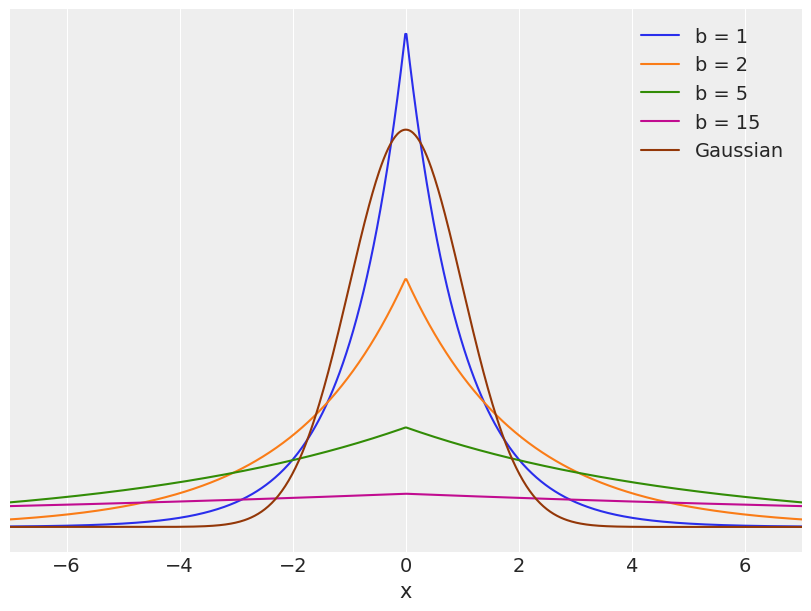

In [23]:
plt.figure(figsize=(8, 6))
x_values = np.linspace(-10, 10, 1000)
for df in [1, 2, 5, 15]:
    distri = stats.laplace(scale = df)
    x_pdf = distri.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f'b = {df}')
    
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, label = 'Gaussian')
plt.xlabel('x')
plt.yticks([])
plt.legend()
plt.xlim(-7, 7)

## Entropy

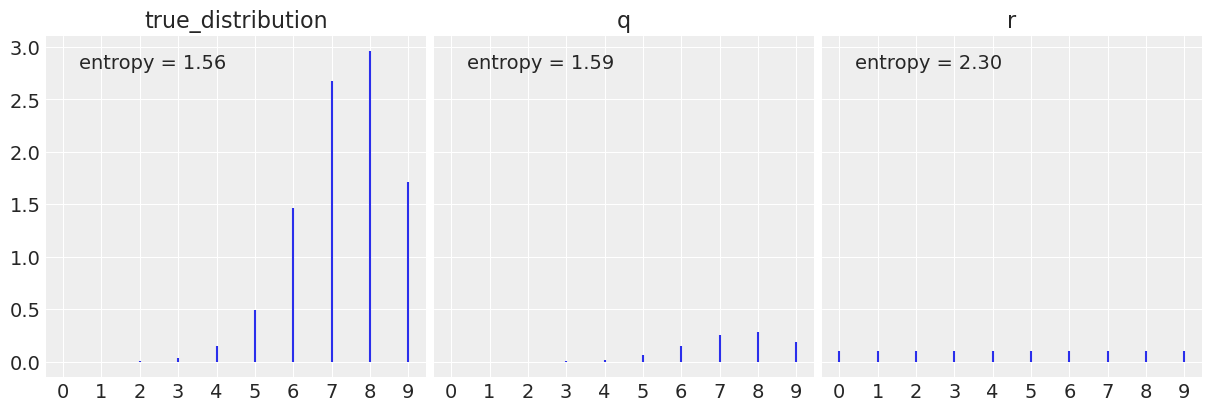

In [24]:
np.random.seed(789)
x = range(0, 10)
q = stats.binom(10, 0.75)
r = stats.randint(0, 10)

true_distribution = [list(q.rvs(2000)).count(i) / 200 for i in x]

q_pmf = q.pmf(x)
r_pmf = r.pmf(x)

_, ax = plt.subplots(1, 3, figsize = (12, 4), sharey=True,
                    constrained_layout = True)

for idx, (dist, label) in enumerate(zip([true_distribution, q_pmf, r_pmf], ['true_distribution', 'q', 'r'])):
    ax[idx].vlines(x, 0, dist, label = f'entropy = {stats.entropy(dist):.2f}')
    ax[idx].set_title(label)
    ax[idx].set_xticks(x)
    ax[idx].legend(loc=2, handlelength=0)

즉 엔트로피가 클 수록 분포가 더 넓게 퍼져있는 것을 볼 수 있다.

In [25]:
f"{stats.entropy(true_distribution, q_pmf):.2f}" , f"{stats.entropy(true_distribution, r_pmf):.2f}"

('0.00', '0.74')

KL divergence 계산.  
q분포와 r분포중 어느 것이 true_distribution과 가까운지 계산하였고, q분포의 KL divergence 값이 작아서 q 분포가 true_distribution과 유사한 것을 확인 가능.

In [26]:
f"{stats.entropy(r_pmf, q_pmf):.2f}", f"{stats.entropy(q_pmf, r_pmf):.2f}"

('2.76', '0.72')

KL divergence는 non-symmetric 연산이다. 두 항을 교환해주니 전혀 다른 값이 나왔다.